# Model 2: with feature selection based on correlations & undersampling

In [2]:
# import libraries
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
#import data (continue with subsample 3 only as this was used for model 1)
dfall = pd.read_csv('CreditCardFraud_AllData.csv')
df3 = pd.read_csv('CreditCardFraud_3.csv')

In [4]:
# Need to scale the data in the columns Time and Amount 
std_scaler = StandardScaler()

dfall['scaled_amount'] = std_scaler.fit_transform(dfall['Amount'].values.reshape(-1,1))
dfall['scaled_time'] = std_scaler.fit_transform(dfall['Time'].values.reshape(-1,1))
dfall.drop(['Time','Amount'], axis=1, inplace=True)

df3['scaled_amount'] = std_scaler.fit_transform(df3['Amount'].values.reshape(-1,1))
df3['scaled_time'] = std_scaler.fit_transform(df3['Time'].values.reshape(-1,1))
df3.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:
# Create an undersampled version of the dataset to balance classes 
X_all = df3.iloc[:, df3.columns != 'Is.Fraud']
y_all = df3.iloc[:, df3.columns == 'Is.Fraud']

# Count number of data points in the minority class
fraud_count = len(df3[df3['Is.Fraud'] == 1])

# Create separate arrays for the different cases (fraud / not fraud)
fraud_trans = np.array(df3[df3['Is.Fraud'] == 1].index)
normal_trans = df3[df3['Is.Fraud'] == 0].index

# Out of the normal transactions, select "fraud_count" number of transactions randomly
random_normal_trans = np.random.choice(normal_trans, fraud_count, replace = False)
random_normal_trans = np.array(random_normal_trans)

# Combining the normal and fraud transaction
under_sample_trans = np.concatenate([fraud_trans,random_normal_trans])

# Create the undersampled dataset
under_sample_data = df3.iloc[under_sample_trans,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Is.Fraud']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Is.Fraud']

# Print result
print("Proportion of non-fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 0])/len(under_sample_data))
print("Proportion of fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 1])/len(under_sample_data))
print("Total number of transactions in undersampled data: ", len(under_sample_data))

Proportion of non-fraud transactions:  0.5
Proportion of fraud transactions:  0.5
Total number of transactions in undersampled data:  984


True     492
False    492
Name: Is.Fraud, dtype: int64


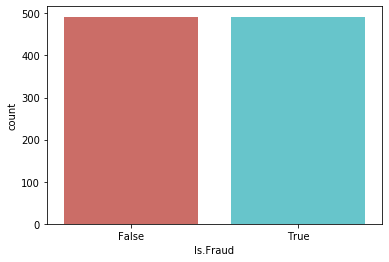

In [6]:
# Check that the classes are balanced
fraud_class = under_sample_data['Is.Fraud'].value_counts()
print(fraud_class)
sns.countplot(x='Is.Fraud',data=under_sample_data, palette='hls')

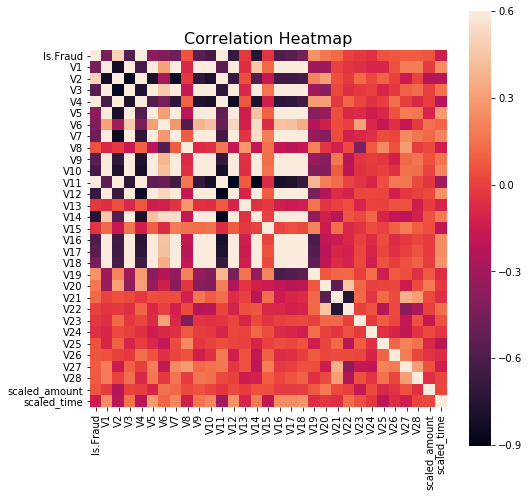

In [7]:
# check correlations 
correlation = under_sample_data.corr()
f , ax = plt.subplots(figsize = (8,8)) 
plt.title('Correlation Heatmap',y=1,size=16) 
sns.heatmap(correlation, square = True, vmax=0.6)

In [8]:
#want to find the features which have the strongest correlation with fraud
correlation = under_sample_data.corr()['Is.Fraud'][1:]

#Make a list of the features which have a correlation with absolute value larger than 0.5 to list out
features_list = correlation[abs(correlation) > 0.5].sort_values(ascending=False)
print("There is {} values which are notably correlated with Is.Fraud:\n{}".format(len(features_list), features_list))

There is 10 values which are notably correlated with Is.Fraud:
V4     0.708079
V11    0.687578
V2     0.503697
V9    -0.546035
V17   -0.560619
V3    -0.568831
V16   -0.595735
V10   -0.632022
V12   -0.683447
V14   -0.750988
Name: Is.Fraud, dtype: float64


In [9]:
# Choose the columns we want to use to predict fraud with using correlation
names = ['Is.Fraud','V3', 'V4','V9', 'V10','V11', 'V12', 'V14','V16','V17']
train_cols = names[1:]

# Use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.381905
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:                  0.4490
Time:                        12:32:22   Log-Likelihood:                -375.79
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                4.746e-127
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V3            -0.1937      0.073     -2.640      0.008      -0.338      -0.050
V4             0.2263      0

In [10]:
# Split subset 3 into test and train sets

X3 = df3.iloc[:, df3.columns != 'Is.Fraud']
y3 = df3.iloc[:, df3.columns == 'Is.Fraud']

X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X3_train))
print("Transactions test dataset: ", len(X3_test))
print("Total transactions: ", len(X3_train)+len(X3_test))


# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X_train))
print("Transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

Transactions train dataset:  3500
Transactions test dataset:  1500
Total transactions:  5000
Transactions train dataset:  688
Transactions test dataset:  296
Total transactions:  984


In [11]:
print(df3[train_cols].head())
print(under_sample_data[train_cols].head())

         V3        V4        V9       V10       V11       V12       V14  \
0  0.924591 -0.727219 -0.665271 -0.737980  0.324098  0.277192 -0.291896   
1  1.146088  0.656290 -0.523849  0.690440  1.160793  0.831569 -0.018098   
2 -0.268073  0.125245 -0.230000  0.295110 -0.596572 -0.118181  0.063381   
3  1.230334  2.554474  0.307571  0.475235 -1.410625 -0.508594 -0.199105   
4  2.528964  0.648279  0.435493 -0.308060 -0.678178 -0.219642 -0.383811   

        V16       V17  
0  1.143174 -0.928709  
1 -0.180816 -0.749369  
2 -0.608157 -0.159370  
3  0.541796 -0.274024  
4 -0.471960  0.419925  
            V3        V4        V9       V10       V11        V12       V14  \
4508 -1.609851  3.997906 -2.770089 -2.772272  3.202033  -2.899907 -4.289254   
4509  1.088463  2.288644 -0.270953 -0.838587 -0.414575  -0.503141 -1.692029   
4510 -0.359745  2.330243 -0.238253 -1.525412  2.032912  -6.560124 -1.470102   
4511 -2.592844  2.679787 -0.247768 -4.801637  4.895844 -10.912819 -6.771097   
4512 -4.30

In [12]:
#we fit and predict a model on the undersampled data first
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.96


In [13]:
from sklearn.metrics import confusion_matrix

#Look at confusion matrix
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[147   2]
 [ 11 136]]


Text(0.5, 257.44, 'Predicted label')

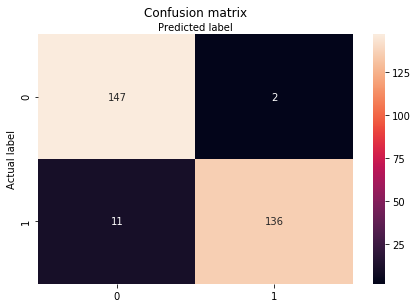

In [14]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       149
        True       0.99      0.93      0.95       147

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



In [16]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy of logistic regression classifier on test set: 0.97


In [17]:
from sklearn.metrics import confusion_matrix

#Look at confusion matrix
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1317   34]
 [  14  135]]
              precision    recall  f1-score   support

       False       0.99      0.97      0.98      1351
        True       0.80      0.91      0.85       149

    accuracy                           0.97      1500
   macro avg       0.89      0.94      0.92      1500
weighted avg       0.97      0.97      0.97      1500



Text(0.5, 257.44, 'Predicted label')

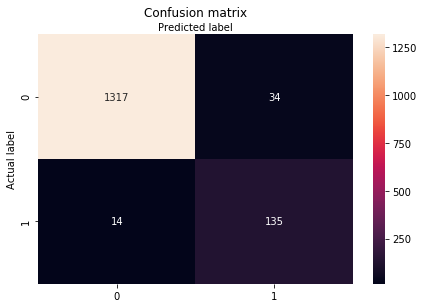

In [18]:
# Better looking confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Model 3: Using feature selection methods (RFE & Lasso)

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import StratifiedKFold

feature_names = list(X_undersample.columns.values)

In [22]:
# test RFE (recursive feature elimination) for feature selection
 
logreg = LogisticRegression(solver='lbfgs')

# specify that we want 9 features to compare with our own selection above
rfe = RFE(logreg, 9)
rfe = rfe.fit(X_undersample, y_undersample.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print('Selected features: %s' % list(X_undersample.columns[rfe.support_]))

[False False False  True False False False  True  True  True False  True
  True  True False False False False False  True False False False False
 False False False False  True False]
[10 19 18  1  3 12 20  1  1  1  2  1  1  1 15  4  9 22 14  1 17  6 16 21
 11 13  5  8  1  7]
Selected features: ['V4', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V20', 'scaled_amount']


In [23]:
names = ['Is.Fraud','V2', 'V4', 'V10', 'V11', 'V12', 'V14', 'V20', 'V22', 'V26']
train_cols3 = names[1:]

#We use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols3]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.387176
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:                  0.4414
Time:                        12:37:59   Log-Likelihood:                -380.98
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                8.067e-125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V2             0.0393      0.064      0.617      0.537      -0.085       0.164
V4             0.1960      0

In [24]:
# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols3],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X3_train))
print("Transactions test dataset: ", len(X3_test))
print("Total transactions: ", len(X3_train)+len(X3_test))


# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols3],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X_train))
print("Transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

Transactions train dataset:  3500
Transactions test dataset:  1500
Total transactions:  5000
Transactions train dataset:  688
Transactions test dataset:  296
Total transactions:  984


In [26]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[146   3]
 [ 12 135]]


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95       149
        True       0.98      0.92      0.95       147

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296



In [29]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy of logistic regression classifier on test set: 0.97


In [30]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1316   35]
 [  15  134]]
              precision    recall  f1-score   support

       False       0.99      0.97      0.98      1351
        True       0.79      0.90      0.84       149

    accuracy                           0.97      1500
   macro avg       0.89      0.94      0.91      1500
weighted avg       0.97      0.97      0.97      1500



Text(0.5, 257.44, 'Predicted label')

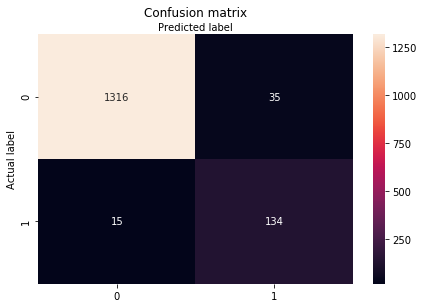

In [31]:
#Make better looking confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_undersample,y_undersample.values.ravel(),test_size = 0.3, random_state = 0)
      
lasso001 = Lasso(alpha=0.1, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print("training score for alpha=0.01:", train_score001) 
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)
print(lasso001.coef_)
features = abs(lasso001.coef_) > 0
print('Selected features: %s' % list(X_undersample.columns[features]))

training score for alpha=0.01: 0.5972767316990493
test score for alpha =0.01:  0.585289471323373
number of features used: for alpha =0.01: 4
[-0.00540245  0.         -0.          0.02094382  0.         -0.
  0.         -0.00178391  0.         -0.          0.         -0.
 -0.         -0.0627163  -0.         -0.          0.          0.
 -0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.          0.        ]
Selected features: ['V1', 'V4', 'V8', 'V14']


In [35]:
names = ['Is.Fraud','V1', 'V3', 'V4', 'V8', 'V14']
train_cols4 = names[1:]

# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols4],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X3_train))
print("Transactions test dataset: ", len(X3_test))
print("Total transactions: ", len(X3_train)+len(X3_test))

logreg = LogisticRegression()
logreg.fit(X3_train, y3_train)
train_score=logreg.score(X3_train,y3_train)
test_score=logreg.score(X3_test,y3_test)
print("Training score:", train_score) 
print("Test score: ", test_score)

y_pred3 = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y3_test, y_pred3)
print(confusion_matrix)
print(classification_report(y3_test, y_pred3))


Transactions train dataset:  3500
Transactions test dataset:  1500
Total transactions:  5000
Training score: 0.9825714285714285
Test score:  0.9806666666666667
Accuracy of logistic regression classifier on test set: 0.98
[[1343    8]
 [  21  128]]
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      1351
        True       0.94      0.86      0.90       149

    accuracy                           0.98      1500
   macro avg       0.96      0.93      0.94      1500
weighted avg       0.98      0.98      0.98      1500



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 257.44, 'Predicted label')

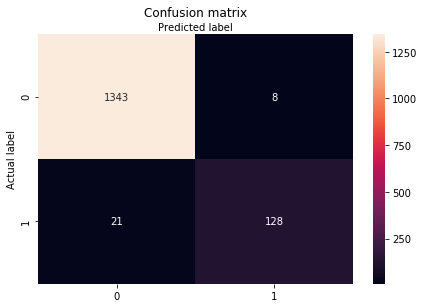

In [36]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')